# Single analysis notebook

This notebook aims to create enviroment to simply test strategies developed in Stocks & Loss system for python

In [66]:
# imports 
from scraper import stock_daily
from analyzer import Analyzer
from IPython.display import display
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import indicators as ind

## Settings
* Select stock ticker
* Define buy and sell strategy (buystrat and sellstrat)
* Define if you want to run stop loss and what value
* Same with profit taker

In [67]:
ticker = "AAPL"
# stop loss
sl = True
slval = 0.08
# profit taker
pt = True
ptval = 0.11
# repeteated buys
rb = False

## Running calculation

In [68]:
# scraping / loading data
stock = stock_daily(ticker, save=False)
# creating analyzer instance
trades = Analyzer(ticker=ticker, data=stock.data)

## Building the trade strategy

In [69]:
# ================> Buy strategy: SMA cross
# STRATEGY DEFINITIONS
# calculating VFI
vfi = ind.vfi(stock.data, period=30, coef=0.2, vcoef=1.5)
# calculating VFI histogram trend
window = 6
trend = vfi["histogram"].rolling(window=window).apply(lambda x: np.polyfit(np.arange(window), x, 1)[0], raw=True).values
trend = trend > 0.08
# buy signals in uptrend
bss = trades.mb_stoch(period=21, sk=3, sd=5, treshold=20, tcross="d")
# finalize buy signals
bsf = np.logical_and(trend, bss)
# throw exception if buy signal is empty
if bsf.sum() == 0:
    raise RuntimeError("No buy signals were generated by this strategy.")

# WRITE SELL METHOD WHICH CREATES 
# ================> Sell strategy: SMA cross
# for N buy signals, create N sell vectors where Nth column will be the sell signal for Nth buy signal, 
# some sell methods that are independent will have copied columns
ss = np.roll(bsf,5)
ssf = np.repeat([ss,], repeats=np.sum(bsf), axis=0)

# sort signals
ss = trades.signalSorter(bsf,ssf,rb) 

In [70]:
# building final strategy
trades.strategy(ss, stopLoss=sl, stopLossValue=slval, profitTaker=pt, profitTakerValue=ptval)
# evaluating strategy
summary = trades.profit(capitalForEachTrade=500, comission=2)
profitByHolding = 100*((trades.data["Close"].iloc[-1]-trades.data["Close"].iloc[0])/trades.data["Close"].iloc[0])

# dates for plot
# taking stock.data and changing index to column and Date to index
dates = stock.data.copy()
dates["index1"] = dates.index
dates = dates.set_index("Date")

# find index of buy dates of good trades
bdg = summary["Buy date"].where(summary["Good trade?"].astype("bool")).dropna().to_numpy()
sdg = summary["Sell date"].where(summary["Good trade?"].astype("bool")).dropna().to_numpy()
bdg = dates["index1"].reindex(bdg).to_numpy()
sdg = dates["index1"].reindex(sdg).to_numpy()
   
# find index of buy dates of bad trades
bdb = summary["Buy date"].where(~summary["Good trade?"].astype("bool")).dropna().to_numpy()
sdb = summary["Sell date"].where(~summary["Good trade?"].astype("bool")).dropna().to_numpy()
bdb = dates["index1"].reindex(bdb).to_numpy()
sdb = dates["index1"].reindex(sdb).to_numpy()

In [71]:
summary.shape[0]

8

# Results

In [72]:
print('Absolute profit last year:                ',np.round(summary["Profit[$]"].sum(),2),'$')
print('Relative profit last year:                ',np.round(summary["Profit[%]"].sum(),2),'%')
print('Relative profit by holding last year:     ',np.round(profitByHolding,2),'%')

Absolute profit last year:                 20.73 $
Relative profit last year:                 4.15 %
Relative profit by holding last year:      32.4 %


In [73]:
display(summary)

,Buy date,Buy price,Buy value,Position,Sell date,Sell price,Sell value,Comission,Good trade?,Profit[$],Profit[%]
0,2020-11-30,118.670799,500,4.213336,2020-12-07,123.355827,519.739599,2,1.0,17.739599,3.547920
1,2021-01-11,128.569168,500,3.888957,2021-01-19,127.422829,495.541935,2,0.0,-6.458065,-1.291613
2,2021-03-02,124.907837,500,4.002951,2021-03-09,120.884666,483.895444,2,0.0,-18.104556,-3.620911
3,2021-03-15,123.779747,500,4.039433,2021-03-22,123.180771,497.580476,2,0.0,-4.419524,-0.883905
4,2021-03-31,121.942871,500,4.100281,2021-04-08,130.138947,533.606210,2,1.0,31.606210,6.321242
5,2021-06-04,125.889999,500,3.971721,2021-06-11,127.349998,505.798710,2,1.0,3.798710,0.759742
6,2021-07-15,148.479996,500,3.367457,2021-07-22,146.800003,494.342697,2,0.0,-7.657303,-1.531461
7,2021-08-05,147.059998,500,3.399973,2021-08-12,148.889999,506.221957,2,1.0,4.221957,0.844391


## Visualizations

Successful trades are showcased as a light green fill, similarly, failed trades as a red fill

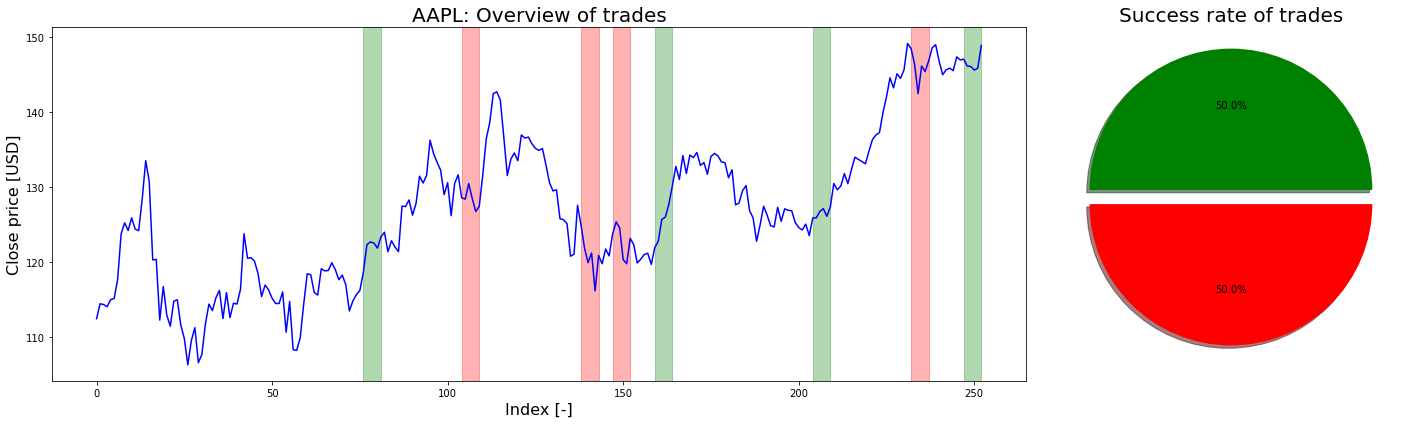

In [74]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6), gridspec_kw={'width_ratios': [2.5, 1]})

# plot closed prices and highlighted trades
ax[0].plot(stock.data["Close"], color="b")
for i, val in enumerate(bdg):
    ax[0].axvspan(val, sdg[i], alpha=0.3, color="g")
for i, val in enumerate(bdb):
    ax[0].axvspan(val, sdb[i], alpha=0.3, color="r")
ax[0].set_title(ticker + ": Overview of trades", fontsize=20)
ax[0].set_ylabel("Close price [USD]", fontsize=16)
ax[0].set_xlabel("Index [-]", fontsize=16)

gtrades = summary["Good trade?"].sum()
btrades = summary["Good trade?"].size
# plot piechart with percentage of succesful trades (profit / loss)
ax[1].pie([gtrades, btrades-gtrades], colors=["g","r"], shadow=True, explode=(0.1, 0), autopct="%1.1f%%")
ax[1].set_title("Success rate of trades", fontsize=20)

fig.tight_layout()

Text(0.5, 0, 'Index [-]')

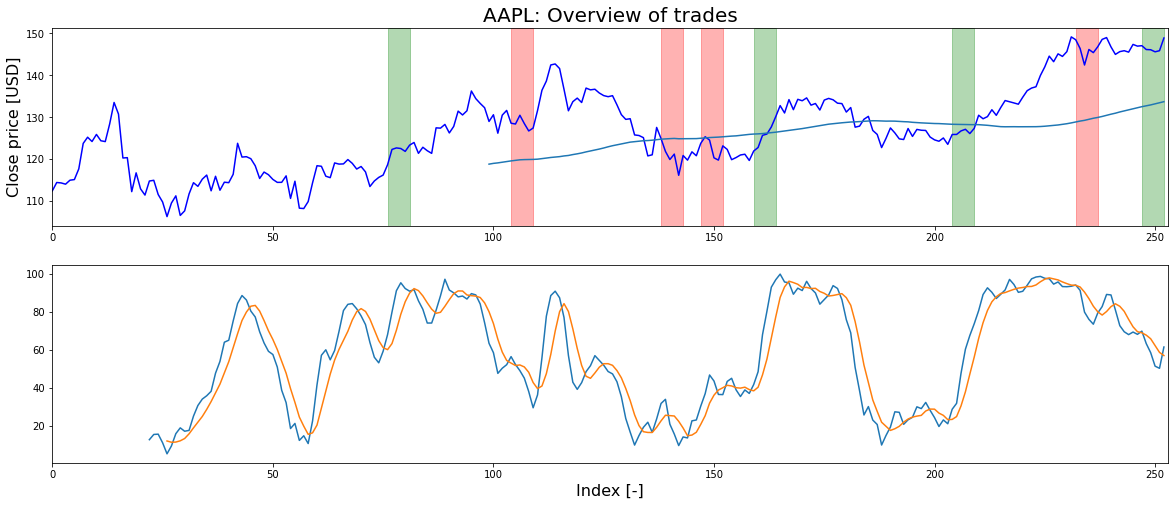

In [75]:
fig, ax = plt.subplots(nrows=2, figsize=(20,8))

# plot closed prices and highlighted trades
ax[0].plot(stock.data["Close"], color="b")
ax[0].plot(ind.sma(stock.data, 100)["SMA"])
for i, val in enumerate(bdg):
    ax[0].axvspan(val, sdg[i], alpha=0.3, color="g")
for i, val in enumerate(bdb):
    ax[0].axvspan(val, sdb[i], alpha=0.3, color="r")
ax[0].set_title(ticker + ": Overview of trades", fontsize=20)
ax[0].set_ylabel("Close price [USD]", fontsize=16)
ax[0].set_xlim([0, stock.data.shape[0]])

ax[1].plot(ind.stoch(stock.data, period=21, sk=3, sd=5)["k"])
ax[1].plot(ind.stoch(stock.data, period=21, sk=3, sd=5)["d"])
ax[1].set_xlim([0, stock.data.shape[0]])
ax[1].set_xlabel("Index [-]", fontsize=16)